# Simple Calculator using Reverse Polish Notation

[**Reverse Polish Notation (RPN)**](https://en.wikipedia.org/wiki/Reverse_Polish_notation), also known as **Polish Postfix Notation** or simply **Postfix Notation**, is a mathematical notation in which operators follow their operands, in contrast to **Polish Notation (PN)**, in which operators precede their operands. It does not need any parentheses as long as each operator has a fixed number of operands. The description **"Polish"** refers to the nationality of logician **Jan Łukasiewicz**, who invented **Polish notation** in 1924.<br/>

The **reverse Polish** scheme was proposed in 1954 by **Arthur Burks, Don Warren,** and **Jesse Wright** and was independently reinvented by **Friedrich L. Bauer** and **Edsger W. Dijkstra** in the early 1960s to reduce computer memory access and utilize the stack to evaluate expressions. The algorithms and notation for this scheme were extended by Australian philosopher and computer scientist **Charles L. Hamblin** in the mid-1950s.<br/>

**Postfix Notataion** remove all the parentheses and make the process of calculate expression much easier, especially for computer.<br/>

In order to understand **Postfix Notation**, we can use an [**Expression Tree**](https://en.wikipedia.org/wiki/Binary_expression_tree) to visualize this expression:
**-sqrt(36.2 - 5.3) + 2 - (3.1 + 5.52) * 4 / -3.0**

![Expression Tree](https://s2.upanh.pro/2018/08/09/tree.png)

That expression will be **"36.2 5.3 - sqrt - 2.0 + 3.1 5.52 + 4.0 * -3.0 / - -"** in **Postfix Notation**

In the next section, I will show you how we can convert an **Infix Expression** into a **Postfix Expression**, evaluate it and then plot a **Binary Expression Tree** like that.

## 1. Pre-processing and prepraring:
Our input will be a string, so I will remove any space, then add some necessary space and replace some special case like two minus character '--' to one plus character '+' to Normalize our expression. Finally, I used [**Regular Expression**](https://en.wikipedia.org/wiki/Regular_expression) to slice that string in to a list of operand and operator. We also need to check if there are any **variable** in the expression.<br/>

**Note:** We might not need to mess with string if we can use **Regular Expression** to solve all the pre-processing thing when slice the expression. I don't have strong experience in **Regex** so this is what I did for now.

In [1]:
import re

def preprocessExpression(string):
    """Convert a expression string to a list of operand and operator"""
    string = string.replace(' ', '')
    string = string.replace(')-', ') - ')
    string = string.replace(')(', ')*(')
    string = string.replace('*-', ' * -')
    string = string.replace('/-', ' / -')
    string = string.replace('+-', ' + -')
    string = string.replace('--', ' + ')
    string = string.replace(')sqrt', ')*sqrt')
    if len(string) != 1:
        i = 1
        while True:
            while string[i] == '-' and (string[i - 1].isdigit() or string[i - 1]=='x') and (string[i + 1].isdigit() or string[i + 1]=='x'):
                string = string[:i] + ' ' + string[i] + ' ' + string[i + 1:]
            i += 1
            if i == len(string):
                break
        i = 0
        while True:
            while ((string[i].isdigit() or string[i]=='x') and string[i + 1] == '(') or (string[i] == ')' and (string[i + 1].isdigit() or string[i+1] == 'x')) or (string[i].isalpha() and string[i+1].isdigit()) or (string[i].isdigit() and string[i+1].isalpha()):
                string = string[:i+1] + '*' + string[i+1:]
            i += 1
            if i == len(string)-1:
                break
    exp = re.findall(r'(-*[0-9,\.]+)|([*+^\/-]+|[A-Za-z]+)|(\(|\))', string)
    exp = [tuple(j for j in i if j)[-1] for i in exp]
    for i, x in enumerate(exp):
        try:
            exp[i] = float(x)
        except ValueError:
            pass
    haveVarible = True if 'x' in exp else False
    return exp, haveVarible

Let's try it out:

In [2]:
_input1 = "3x^2+8-3"
_input2 = "-sqrt(36.2 - 5.3) + 2 - (3.1 + 5.52) * 4 / -3.0"
exp1, haveVarible1 = preprocessExpression(_input1)
exp2, haveVarible2 = preprocessExpression(_input2)
print(exp1)
print(haveVarible1)
print(exp2)
print(haveVarible2)

[3.0, '*', 'x', '^', 2.0, '+', 8.0, '-', 3.0]
True
['-', 'sqrt', '(', 36.2, '-', 5.3, ')', '+', 2.0, '-', '(', 3.1, '+', 5.52, ')', '*', 4.0, '/', -3.0]
False


**Perfect!** Next, we have to determine which operator will have higher priority. In this calculator, I will use 6 operators: **+ - * / ^** and **sqrt**. We can add any operators like **sin, cos, log, ln, ...** easily down the lines:

In [3]:
def notGreater(i, j):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2, '^': 3, 'sqrt': 4}
    try:
        a = precedence[i]
        b = precedence[j]
        return True if a <= b else False
    except KeyError:
        return False

## 2. Convert Infix Expressions to Postfix Expressions:
We can convert **Infix Expressions** to **Postfix Expressions** by using [**Shunting-Yard Algorithm**](https://en.wikipedia.org/wiki/Shunting-yard_algorithm), **Edsger Dijkstra** invented it, so named because its operation resembles that of a railroad shunting yard.

Here is the **Shunting-Yard Algorithm**:
* **Step 1:** Scan the infix expression from left to right.
* **Step 2:** If the scanned character is an operand or a variable, output it.
* **Step 3:** Else,
    * If the precedence of the scanned operator is greater than the precedence of the operator in the stack(or the stack is empty), push it.
    * Else, Pop the operator from the stack until the precedence of the scanned operator is less-equal to the precedence of the operator residing on the top of the stack. Push the scanned operator to the stack.
* **Step 4:** If the scanned character is an ‘(‘, push it to the stack.
* **Step 5:** If the scanned character is an ‘)’, pop and output from the stack until an ‘(‘ is encountered.
* **Step 6:** Repeat steps 2-6 until infix expression is scanned.
* **Step 7:** Pop and output from the stack until it is not empty.

In [4]:
def infixToPostfix(exp):
    """Convert infix expression to postfix expression"""
    output = []
    stack = []
    for i in exp:
        if type(i) is float or i == 'x':
            output.append(i)
        elif i == '(':
            stack.append('(')
        elif i == ')':
            while stack and stack[-1] != '(':
                a = stack.pop()
                output.append(a)
            if stack and stack[-1] != '(':
                return -1
            else:
                stack.pop()
        else:
            while stack and notGreater(i, stack[-1]):
                output.append(stack.pop())
            stack.append(i)
    while stack:
        output.append(stack.pop())
    return output

Let's do a quick test:

In [5]:
postfix1 = infixToPostfix(exp1)
postfix2 = infixToPostfix(exp2)
print(postfix1)
print(postfix2)

[3.0, 'x', 2.0, '^', '*', 8.0, '+', 3.0, '-']
[36.2, 5.3, '-', 'sqrt', '-', 2.0, '+', 3.1, 5.52, '+', 4.0, '*', -3.0, '/', '-']


Because each token will be read once, each number, function, or operator will be printed once, and each function, operator, or parenthesis will be pushed onto the stack and popped off the stack once—therefore, there are at most a constant number of operations executed per token, and the running time is thus ***O(n)*** — linear in the size of the input.

# 3. Evaluate Prefix Expressions:
Now we have an **Prefix Expression**, we need to evaluate it for our calculators output:
* **Step 1:** Create a stack to store operands (or values).
* **Step 2:** Scan the given expression and do following for every scanned element.
    * If the element is a number, push it into the stack.
    * If the element is a variable, push it's value to the stack.
    * If the element is a operator, pop operands for the operator from stack. Evaluate the operator and push the result back to the stack.
* **Step 3:** When the expression is ended, the number in the stack is the final answer.

In [6]:
from math import sqrt

def evaluatePostfix(postfix, x):
    """Evaluate a postfix expression"""
    stack = []
    for i in postfix:
        if type(i) is float:
            stack.append(i)
        elif i == 'x':
            stack.append(x)
        else:
            if i == 'sqrt':
                val = stack.pop()
                stack.append(sqrt(val))
            elif i == '-' and len(stack) == 1:
                val = stack.pop()
                stack.append(-val)
            else:
                val1 = stack.pop()
                val2 = stack.pop()
                if i == '+':
                    stack.append(val2 + val1)
                elif i == '-':
                    stack.append(val2 - val1)
                elif i == '*':
                    stack.append(val2 * val1)
                elif i == '/':
                    stack.append(val2 / val1)
                elif i == '^':
                    stack.append(val2**val1)
    return stack.pop()

In [7]:
res1 = evaluatePostfix(postfix1,float(input("x=")))
res2 = evaluatePostfix(postfix1,0)
print(res1)
print(res2)

x=3.14
34.5788
5.0


Time complexity of evaluation algorithm is ***O(n)*** where n is number of characters in input expression.

# 4. Plug everything in a simple calculator:
All the hard problems have been solved, it's time for our simple console based calculator, let's catch some error and we are good to go ^^

In [8]:
# Test expression: -sqrt(36.2 - 5.3) + 2 - (3.1 + 5.52) * 4 / x"
try:
    expression = input("Input your expression: ")
    expression, haveVarible = preprocessExpression(expression)
    postfix = infixToPostfix(expression)
    print("Postfix expression: ", end='')
    for each in postfix:
        print(str(each), ' ', end='')
    if haveVarible:
        x = float(input("\nInput value of x: "))
        print('\nValue of expression:', evaluatePostfix(postfix, x))
    else:
        print('\nValue of expression:', evaluatePostfix(postfix, 0))
except ValueError:
    print("Math Error!")
except IndexError:
    print("Expression Not Valid")

Input your expression: -sqrt(36.2 - 5.3) + 2 - (3.1 + 5.52) * 4 / x
Postfix expression: 36.2  5.3  -  sqrt  -  2.0  +  3.1  5.52  +  4.0  *  x  /  -  
Input value of x: -3.0

Value of expression: 7.934556489458414


**And it's worked !**

![It's worked](http://sv1.upsieutoc.com/2018/08/09/Screen-Shot-2018-08-09-at-11.55.51.png)

# 5. Plot the Expression Tree:

In order to understand how everything works, we might need to use a **Binary Expression Tree** to visualize the expression. **Prefix Notation** help up construct the binary tree way easier than **Infix Notation**. The process of construct an **Expression Tree** is pretty much the same when we evaluate the **Prefix Expression**.

I used **[anytree](https://anytree.readthedocs.io/en/latest/intro.html)**, a simple and powerful Python **tree data library** to construct and plot our tree.

Since **Binary Expression Tree** is **undirected tree**, I have to make a **edege type function** make sure anytree output the correct tree:

In [9]:
def edgetypefunc(node, child):
    """Return undirected egde for undirected tree export"""
    return '--'

Each node of the tree have **a key** in **anytree's Node Class**, so we **can't use a operand or operator** for that key since there might be are a lot of operand or operator got **dupicated** in an expression. But we still can save that value by a additional **kwargs**, so we have to tell anytree to render tree using that **kwargs**.

In [10]:
def nodeattrfunc(node):
    """Export to DOT by value of node"""
    return 'label="' + str(node.val) + '"'

Here is how we will construct an **Expression Tree** from an **Prefix Expression**:
* **Step 1:** Create a stack to store node and an index for those node
* **Step 2:** Scan the prefix expression from left to right and do following for every scanned element.
    * If the element is a number or variable, create a node for it with new index and push it to the stack
    * If the element is a operator:
        * Create a node for it with new index
        * Pop the operands for that operator from stack then set their parent to the operator node
        * Push the parent node to the stack

* At the end, there should be **only one node** left in the stack and it is the **root** node of our **Expression Tree**

In [11]:
from anytree import Node, RenderTree, DoubleStyle
from anytree.exporter import DotExporter

def drawExpressionTree(postfix):
    """Draw expression tree in console and output to file"""
    stack = []
    index = 0
    for i in postfix:
        if type(i) is float or i == 'x':
            stack.append(Node(index, parent=None, val=i))
            index += 1
        else:
            if i == 'sqrt':
                child = stack.pop()
                parent = Node(index, parent=None, val=i)
                index += 1
                child.parent = parent
                stack.append(parent)
            elif i == '-' and len(stack) == 1:
                child = stack.pop()
                parent = Node(index, parent=None, val=i)
                index += 1
                child.parent = parent
                stack.append(parent)
            else:
                right = stack.pop()
                left = stack.pop()
                parent = Node(index, parent=None, val=i)
                index += 1
                left.parent = parent
                right.parent = parent
                stack.append(parent)
    root = stack.pop()
    DotExporter(root, graph="graph", nodeattrfunc=nodeattrfunc,
                edgetypefunc=edgetypefunc).to_dotfile("tree.dot")
    print("\nExpression Tree:")
    print(RenderTree(root, style=DoubleStyle).by_attr(attrname='val'))

In this function, i used **RenderTree()** function to render our **Expression Tree** in console and **DotExporter** to export our tree to a ***.dot*** file, we can use dot tool from the [graphviz](http://www.graphviz.org/) package to render it into a ***.png*** image. For futher customization and decoration, please head to [Anytree's Documentation](https://anytree.readthedocs.io/en/latest/intro.html):

In [12]:
drawExpressionTree(postfix)


Expression Tree:
-
╠══ +
║   ╠══ -
║   ║   ╚══ sqrt
║   ║       ╚══ -
║   ║           ╠══ 36.2
║   ║           ╚══ 5.3
║   ╚══ 2.0
╚══ /
    ╠══ *
    ║   ╠══ +
    ║   ║   ╠══ 3.1
    ║   ║   ╚══ 5.52
    ║   ╚══ 4.0
    ╚══ x


In [13]:
!dot tree.dot -T png -o tree.png

![Expression Tree](tree.png "Expression Tree")

You can also copy all content inside the **tree.dot** file and use [Webgprahviz](http://www.webgraphviz.com/) to plot the tree right inside your browser:

In [14]:
f = open('tree.dot', 'r')
file_contents = f.read()
print(file_contents)
f.close()

graph tree {
    "14" [label="-"];
    "6" [label="+"];
    "4" [label="-"];
    "3" [label="sqrt"];
    "2" [label="-"];
    "0" [label="36.2"];
    "1" [label="5.3"];
    "5" [label="2.0"];
    "13" [label="/"];
    "11" [label="*"];
    "9" [label="+"];
    "7" [label="3.1"];
    "8" [label="5.52"];
    "10" [label="4.0"];
    "12" [label="x"];
    "14" -- "6";
    "14" -- "13";
    "6" -- "4";
    "6" -- "5";
    "4" -- "3";
    "3" -- "2";
    "2" -- "0";
    "2" -- "1";
    "13" -- "11";
    "13" -- "12";
    "11" -- "9";
    "11" -- "10";
    "9" -- "7";
    "9" -- "8";
}



<img src="https://media.giphy.com/media/2fsdaNR299EuyYtVJ7/giphy.gif">

**Note:** ***anytree*** support render tree to picture with just a simple line of code but it have trouble working with anaconda so i didn't use it. 

# 6. Sub Task - Plot the function of expression: 

For learning purpose, i'll try to plot the **function** from our expression by connect **a collection of dot** in a certain range specify by user input. I will create a list of x value from user input and use our evaluate function before to **calculate the corresponding y value**. Then map them to a **DataFrame** using **pandas** and plot them with **matplotlib**.<br\>

This method works very well for **linear** and **continuous** function.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plotFunction(postfix):
    """Plot a function by connect a collection of points specify by user input"""
    x1 = float(input("\nInput x start: "))
    x2 = float(input("Input x end: "))
    m = int(input("Input number of points: "))
    step = (x2-x1)/m
    x = []
    y = []
    for i in np.arange(x1, x2, step):
        x.append(i)
        y.append(evaluatePostfix(postfix, i))
    df = pd.DataFrame({'x_axis': x, 'y_axis': y})
    print(df)
    fig = plt.figure(num='Ham so')
    ax = fig.add_subplot(111)
    plt.plot('x_axis', 'y_axis', color='green', data=df, linestyle='-', marker='o')
    plt.plot(x, y, 'go-')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.scatter(0, 0)
    plt.grid(True)
    plt.savefig("function.png")
    # plt.show()


Our input expression have to be a **function (contain variable)** in order to use this:


Input x start: -20
Input x end: 20
Input number of points: 40
    x_axis  y_axis
0    -20.0  1205.0
1    -19.0  1088.0
2    -18.0   977.0
3    -17.0   872.0
4    -16.0   773.0
5    -15.0   680.0
6    -14.0   593.0
7    -13.0   512.0
8    -12.0   437.0
9    -11.0   368.0
10   -10.0   305.0
11    -9.0   248.0
12    -8.0   197.0
13    -7.0   152.0
14    -6.0   113.0
15    -5.0    80.0
16    -4.0    53.0
17    -3.0    32.0
18    -2.0    17.0
19    -1.0     8.0
20     0.0     5.0
21     1.0     8.0
22     2.0    17.0
23     3.0    32.0
24     4.0    53.0
25     5.0    80.0
26     6.0   113.0
27     7.0   152.0
28     8.0   197.0
29     9.0   248.0
30    10.0   305.0
31    11.0   368.0
32    12.0   437.0
33    13.0   512.0
34    14.0   593.0
35    15.0   680.0
36    16.0   773.0
37    17.0   872.0
38    18.0   977.0
39    19.0  1088.0


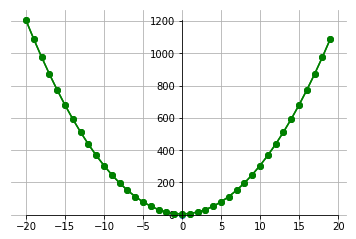

In [22]:
plotFunction(postfix1)

**Note:** This method is **not accurate** for plot any kind of function. Since the step was calculated from user input, **if it's don't meet the value that makes the function value undefined**, our program will **ignore** it and **plot the wrong graph**. You can see the example for the **1/x** function below:


Input x start: -10
Input x end: 10
Input number of points: 10
   x_axis    y_axis
0   -10.0 -0.100000
1    -8.0 -0.125000
2    -6.0 -0.166667
3    -4.0 -0.250000
4    -2.0 -0.500000
5     0.0       inf
6     2.0  0.500000
7     4.0  0.250000
8     6.0  0.166667
9     8.0  0.125000


/Users/lamhoangtung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


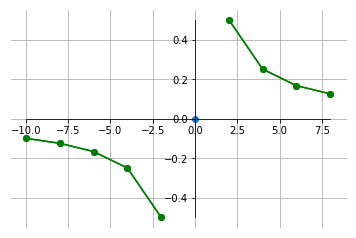

In [25]:
exp, _ = preprocessExpression("1/x")
postfix = infixToPostfix(exp)
plotFunction(postfix)


Input x start: -10
Input x end: 10
Input number of points: 7
      x_axis    y_axis
0 -10.000000 -0.100000
1  -7.142857 -0.140000
2  -4.285714 -0.233333
3  -1.428571 -0.700000
4   1.428571  0.700000
5   4.285714  0.233333
6   7.142857  0.140000


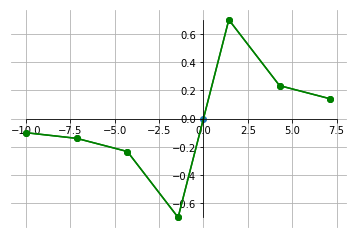

In [26]:
exp, _ = preprocessExpression("1/x")
postfix = infixToPostfix(exp)
plotFunction(postfix)

So, this project is **not prefect**. There are still **a lot of room for improvement** like **better regex for slicing expression, evaluate expression using expression tree and DFS, better method for plot function, etc..** so any contribution will be much appreciated ^^

#### ***Anyways, thanks for read this till the end! Feels free to give me any question or contribute to this project <3***